In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = "/content/drive/MyDrive/OMSCS/DL/FinalProject"
sys.path.append(os.path.abspath(DIR))

from team36.mnist.vgg import VGG
from team36.training import train, validate
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.defenses.fast_gradient_sign_method_loss import FastGradientSignMethodLoss

NAME = "cifar10"
DATA_SET_CLASS = torchvision.datasets.CIFAR10
image_size = 32
in_channels = 3
fgsm_alpha = 0.5
fgsm_epsilon = 0.007

In [3]:
DATA_DIR = f'{DIR}/data'

training_set = DATA_SET_CLASS(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())

training_indices, validation_indices = train_test_split(
    range(len(training_set)),
    test_size=0.1,
)
training_split = torch.utils.data.Subset(training_set, training_indices)
validation_split = torch.utils.data.Subset(training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

Files already downloaded and verified
45000 in training set
5000 in validation set


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0][0/704]	Loss 2.4286 (2.4286)	Prec @1 0.1094 (0.1094)	
Epoch: [0][10/704]	Loss 2.2653 (2.4759)	Prec @1 0.3125 (0.1918)	
Epoch: [0][20/704]	Loss 2.2419 (2.4749)	Prec @1 0.3438 (0.2277)	
Epoch: [0][30/704]	Loss 2.0732 (2.4025)	Prec @1 0.3281 (0.2571)	
Epoch: [0][40/704]	Loss 1.7221 (2.3086)	Prec @1 0.4375 (0.2877)	
Epoch: [0][50/704]	Loss 2.1422 (2.2290)	Prec @1 0.3438 (0.3058)	
Epoch: [0][60/704]	Loss 1.6360 (2.1601)	Prec @1 0.4219 (0.3166)	
Epoch: [0][70/704]	Loss 2.1218 (2.1180)	Prec @1 0.3750 (0.3275)	
Epoch: [0][80/704]	Loss 2.0922 (2.0880)	Prec @1 0.4062 (0.3358)	
Epoch: [0][90/704]	Loss 1.5827 (2.0491)	Prec @1 0.4062 (0.3472)	
Epoch: [0][100/704]	Loss 1.3410 (2.0228)	Prec @1 0.5312 (0.3575)	
Epoch: [0][110/704]	Loss 1.9843 (2.0044)	Prec @1 0.3438 (0.3654)	
Epoch: [0][120/704]	Loss 1.9073 (1.9817)	Prec @1 0.4844 (0.3735)	
Epoch: [0][130/704]	Loss 1.5409 (1.9520)	Prec @1 0.4062 (0.3775)	
Epoch: [0][140/704]	Loss 1.3584 (1.9202)	Prec @1 0.5156 (0.3846)	
Epoch: [0][150/704]	L

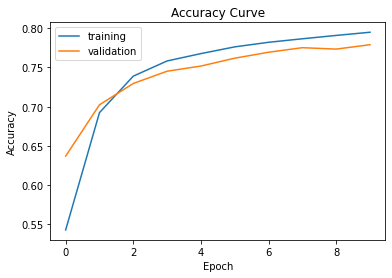

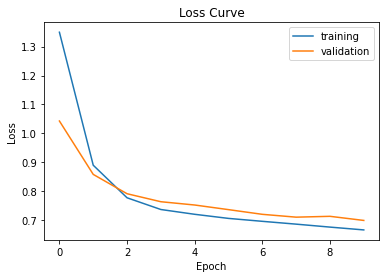

Best Validation Acccuracy: 0.7790


In [4]:
learning_rate = 1e-3
batch_size = 64
momentum = 9e-1
weight_decay = 5e-2
epochs = 10

training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False)

model = VGG(image_size=image_size, in_channels=in_channels).cuda()

criterion = FastGradientSignMethodLoss(model, nn.CrossEntropyLoss(), alpha=fgsm_alpha, epsilon=fgsm_epsilon)

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
validation_accuracy_history = []
validation_loss_history = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion, no_grad=False)
    validation_accuracy_history.append(acc)
    validation_loss_history.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(validation_accuracy_history, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(validation_loss_history, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))

filename = f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-regularization-defense-{fgsm_epsilon}.pth"
torch.save(best_model.state_dict(), filename)